In [1]:
!pip install transformers accelerate ultralytics

In [2]:
from PIL import Image
import numpy as np
import requests
import torch
from IPython.display import display
from google.colab.patches import cv2_imshow
import accelerate
from transformers import DPTForDepthEstimation, DPTFeatureExtractor
import shutil


import os

try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
  source_dir = '/content/gdrive/MyDrive/Study/Code/Python/Data Science Code/Blind_AI/'
except:
  IN_COLAB = False
  source_dir = 'G:/My Drive/Study/Code/Python/Data Science Code/Blind_AI/'

vid_loc_main = source_dir + 'moscow_combined_xmas/Walking tour.mp4'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#
# extract Audio
#

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
import moviepy.editor as mp

# Replace 'output_audio.mp3' with the desired name of the extracted audio file
output_audio_path = 'output_audio.mp3'

# Extract audio from the video
ffmpeg_extract_audio(vid_loc_main, output_audio_path)

# Optional: You can further process the audio using moviepy's AudioFileClip if needed
audio_clip = mp.AudioFileClip(output_audio_path)

# Print the audio duration (in seconds)
print("Audio duration:", audio_clip.duration)

# Close the audio file (cleanup)
audio_clip.close()



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Audio duration: 875.99


In [ ]:
import shutil

# Replace 'source_path' with the path to your pickle file in Colab
source_path = '/content/output_audio.mp3'

# Replace 'destination_path' with the path in your Google Drive where you want to save the file
destination_path = source_dir + 'moscow/output_audio.mp3'

# Copy the file to Google Drive
shutil.copyfile(source_path, destination_path)

'/content/gdrive/MyDrive/Study/Code/Python/Data Science Code/Blind_AI/moscow/output_audio.mp3'

In [3]:
#
# Convert Frames to Videos
#

# Files is a list of images
# f_name is the video name
# The fps of the output video
# Colour will wither apply a colour map to the depth image or convert BGR

def make_video(files, f_name, fps, colour):

  # Define the output video file name and codec
  output_video = f'{f_name}.avi'
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')  # Codec for avi format

  # Read the first image to get dimensions
  first_image = np.asarray(files[0])
  try:
    height, width = first_image.shape
  except:
    height, width, layers = first_image.shape

  # Create a VideoWriter object to write the video
  out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

  # Loop through the image files and write each frame to the video
  for image_file in files:

      image_file = np.asarray(image_file)

      if colour == 'winter':

        image_file = cv2.applyColorMap(image_file, cv2.COLORMAP_WINTER)

      elif colour == 'bgr':
        image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)

      out.write(image_file)

  # Release the VideoWriter object
  out.release()


In [4]:
#
# Convert Videos to Frames
#

# Loc is file location
# Index for start and stop of slice
# Bool Whole will select the whole clip

import cv2

def get_frames(loc, startstop, whole):

    if whole == True:

      # Open the video file
      cap = cv2.VideoCapture(loc)
      # Create a list to store PIL images
      frame_images = []

      # Loop through the video frames and convert them to PIL images
      while True:
          ret, frame = cap.read()
          if not ret:
              break

          # Convert the frame to RGB format (required for PIL)
          frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

          # Convert the RGB frame to a PIL Image
          pil_image = Image.fromarray(frame_rgb)

          # Append the PIL Image to the list
          frame_images.append(pil_image)

    else:
      # Open the video file
      cap = cv2.VideoCapture(loc)
      # Create a list to store PIL images
      frame_images = []

      # Loop through the video frames and convert them to PIL images within the specified range
      current_frame = 0
      while True:
          ret, frame = cap.read()
          if not ret:
              break

          # # Check if the current frame is within the specified range
          if startstop[0] <= current_frame <= startstop[1]:
              #Convert the frame to RGB format (required for PIL)
              frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

              # Convert the RGB frame to a PIL Image
              pil_image = Image.fromarray(frame_rgb)

              # Append the PIL Image to the list
              frame_images.append(pil_image)

          # Increment the current frame counter
          current_frame += 1

    # Release the video file
    cap.release()

    return frame_images


In [ ]:
os.path.isfile(source_dir + 'moscow_combined_xmas/Walking tour.mp4')

True

In [ ]:
file_size_bytes = os.path.getsize('/content/Walking tour.mp4')

# Convert bytes to megabytes (1 MB = 1024 * 1024 bytes)
print(file_size_bytes / (1024 * 1024))

2.0


In [ ]:
#
# Select frames, make sliced video, copy to drive
#

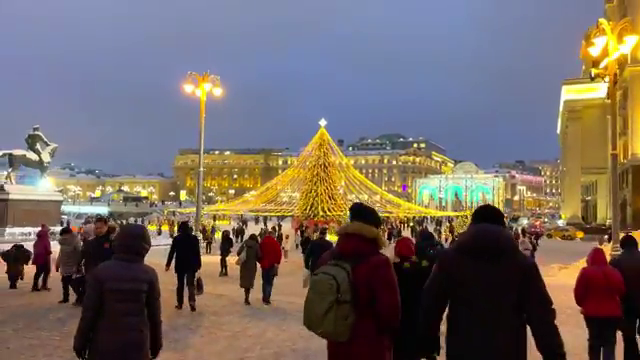

In [6]:
# 14 - 15 ish
startstop = [25200, 27000]

main_imiages1 = get_frames(source_dir + 'moscow_combined_xmas/Walking tour.mp4', startstop, False)
make_video(main_imiages1, 'moscow_xmas_1_vanilla', 30, 'none')

source_path = '/content/moscow_xmas_1_vanilla.avi'

# Replace 'destination_path' with the path in your Google Drive where you want to save the file
destination_path = source_dir + 'moscow_combined_xmas/moscow_xmas_1_vanilla.avi'

# Copy the file to Google Drive
shutil.copyfile(source_path, destination_path)
display(main_imiages1[0])

In [ ]:
#
# Build Depth Perception
#

In [7]:

model_depth = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas", low_cpu_mem_usage=True)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

/usr/local/lib/python3.10/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


In [8]:

def get_depth(images):

  output_list = []

  for image in images:
      # prepare image for the model
    inputs = feature_extractor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model_depth(**inputs)
        predicted_depth = outputs.predicted_depth

    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # visualize the prediction
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    output_list.append(depth)

  return output_list


(640, 360)


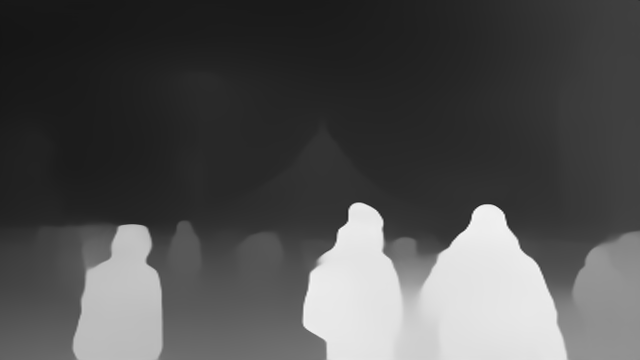

In [10]:

# Get depth images, make video, copy to drive

depth_images1 = get_depth(main_imiages1)

make_video(depth_images1, 'moscow_xmas_1_depth', 30, 'winter')

# Replace 'source_path' with the path to your pickle file in Colab
source_path = '/content/moscow_xmas_1_depth.avi'

# Replace 'destination_path' with the path in your Google Drive where you want to save the file
destination_path = source_dir + '/moscow_combined_xmas/moscow_xmas_1_depth.avi'

# Copy the file to Google Drive
shutil.copyfile(source_path, destination_path)

print(len(depth_images1))
print(depth_images1[0].size)

display(depth_images1[0])


In [ ]:
#
# Build Yolo
#

In [11]:

from ultralytics import YOLO

model_yolo = YOLO("yolov8n.pt")


100%|██████████| 6.23M/6.23M [00:00<00:00, 126MB/s]


In [12]:

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)
    p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
    cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
    if label:
      tf = max(lw - 1, 1)  # font thickness
      w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
      outside = p1[1] - h >= 3
      p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
      cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
      cv2.putText(image,
                  label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                  0,
                  lw / 3,
                  txt_color,
                  thickness=tf,
                  lineType=cv2.LINE_AA)

def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
  #Define colors
  if colors == []:
    #colors = [(6, 112, 83), (253, 246, 160), (40, 132, 70), (205, 97, 162), (149, 196, 30), (106, 19, 161), (127, 175, 225), (115, 133, 176), (83, 156, 8), (182, 29, 77), (180, 11, 251), (31, 12, 123), (23, 6, 115), (167, 34, 31), (176, 216, 69), (110, 229, 222), (72, 183, 159), (90, 168, 209), (195, 4, 209), (135, 236, 21), (62, 209, 199), (87, 1, 70), (75, 40, 168), (121, 90, 126), (11, 86, 86), (40, 218, 53), (234, 76, 20), (129, 174, 192), (13, 18, 254), (45, 183, 149), (77, 234, 120), (182, 83, 207), (172, 138, 252), (201, 7, 159), (147, 240, 17), (134, 19, 233), (202, 61, 206), (177, 253, 26), (10, 139, 17), (130, 148, 106), (174, 197, 128), (106, 59, 168), (124, 180, 83), (78, 169, 4), (26, 79, 176), (185, 149, 150), (165, 253, 206), (220, 87, 0), (72, 22, 226), (64, 174, 4), (245, 131, 96), (35, 217, 142), (89, 86, 32), (80, 56, 196), (222, 136, 159), (145, 6, 219), (143, 132, 162), (175, 97, 221), (72, 3, 79), (196, 184, 237), (18, 210, 116), (8, 185, 81), (99, 181, 254), (9, 127, 123), (140, 94, 215), (39, 229, 121), (230, 51, 96), (84, 225, 33), (218, 202, 139), (129, 223, 182), (167, 46, 157), (15, 252, 5), (128, 103, 203), (197, 223, 199), (19, 238, 181), (64, 142, 167), (12, 203, 242), (69, 21, 41), (177, 184, 2), (35, 97, 56), (241, 22, 161)]
    colors = [(89, 161, 197),(67, 161, 255),(19, 222, 24),(186, 55, 2),(167, 146, 11),(190, 76, 98),(130, 172, 179),(115, 209, 128),(204, 79, 135),(136, 126, 185),(209, 213, 45),(44, 52, 10),(101, 158, 121),(179, 124, 12),(25, 33, 189),(45, 115, 11),(73, 197, 184),(62, 225, 221),(32, 46, 52),(20, 165, 16),(54, 15, 57),(12, 150, 9),(10, 46, 99),(94, 89, 46),(48, 37, 106),(42, 10, 96),(7, 164, 128),(98, 213, 120),(40, 5, 219),(54, 25, 150),(251, 74, 172),(0, 236, 196),(21, 104, 190),(226, 74, 232),(120, 67, 25),(191, 106, 197),(8, 15, 134),(21, 2, 1),(142, 63, 109),(133, 148, 146),(187, 77, 253),(155, 22, 122),(218, 130, 77),(164, 102, 79),(43, 152, 125),(185, 124, 151),(95, 159, 238),(128, 89, 85),(228, 6, 60),(6, 41, 210),(11, 1, 133),(30, 96, 58),(230, 136, 109),(126, 45, 174),(164, 63, 165),(32, 111, 29),(232, 40, 70),(55, 31, 198),(148, 211, 129),(10, 186, 211),(181, 201, 94),(55, 35, 92),(129, 140, 233),(70, 250, 116),(61, 209, 152),(216, 21, 138),(100, 0, 176),(3, 42, 70),(151, 13, 44),(216, 102, 88),(125, 216, 93),(171, 236, 47),(253, 127, 103),(205, 137, 244),(193, 137, 224),(36, 152, 214),(17, 50, 238),(154, 165, 67),(114, 129, 60),(119, 24, 48),(73, 8, 110)]

  counter = 0

  #plot each boxes
  for box in boxes:
    confidence = round(100 * float(box[-2]), 1)
    print(confidence)

    if confidence >= 40.0:
        counter += 1
        #add score in label if score=True
        if score :
          label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
        else :
          label = labels[int(box[-1])+1]
        #filter every box under conf threshold if conf threshold setted
        if conf :
          if box[-2] > conf:
            color = colors[int(box[-1])]
            box_label(image, box, label, color)
        else:
          color = colors[int(box[-1])]
          box_label(image, box, label, color)

  print(counter)
  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image

def extract_object_info(boxes, labels):
    object_info = []
    if labels == []:
      labels = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}
    for box in boxes:
        class_id = int(box[-1]) + 1  # Adjust class ID index
        confidence = round(100 * float(box[-2]), 1)
        label = labels[class_id]
        if confidence >= 40.0:
            x1, y1, x2, y2 = map(int, box[:4])
            info = f"{label}: {confidence}% | Location: ({x1}, {y1}) to ({x2}, {y2})"
            info = [label , confidence, x1,y1, x2, y2]
            object_info.append(info)

    return object_info

def get_yolo(frame_images, show_prob):

  # Define the dimensions of the video frames
  frame_width, frame_height = frame_images[0].size  # Replace with your frame dimensions
  info_results_list = []
  image_results = []

  for index, image in enumerate(frame_images):

      image = np.asarray(image)
      results = model_yolo.predict(image)

      image_yolo = plot_bboxes(image, results[0].boxes.boxes, score=show_prob)
      object_info = extract_object_info(results[0].boxes.boxes, labels=[])
      #
      image_yolo2 = cv2.cvtColor(image_yolo, cv2.COLOR_BGR2RGB)
      image_yolo3 = Image.fromarray(image_yolo2)
      info_results_list.append(object_info)
      image_results.append(image_yolo3)

  return info_results_list, image_results


In [13]:
#
# Build yolo images
#

yolo_info_noprob1, yolo_images_noprob1 = get_yolo(main_imiages1, False)




0: 384x640 12 persons, 1 car, 1 backpack, 205.7ms
Speed: 3.7ms preprocess, 205.7ms inference, 22.6ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.

0: 384x640 12 persons, 1 car, 1 backpack, 142.2ms
Speed: 2.4ms preprocess, 142.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


89.3
89.3
85.5
79.1
73.7
73.5
73.3
68.2
67.0
65.3
61.4
51.8
39.7
30.9
12
89.4
88.2
84.8
80.4
78.8
75.0
74.4
69.0
67.6
67.6
61.4
45.4
40.1
38.1
13


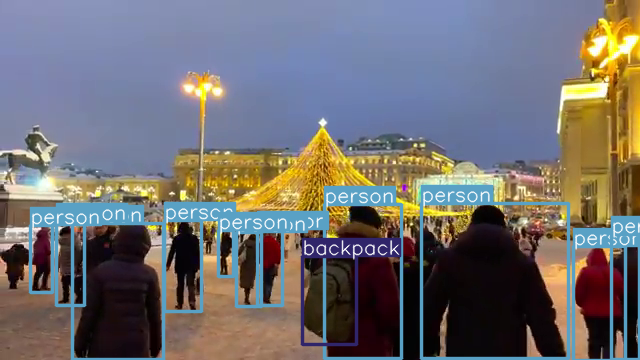

In [14]:
#
# Make video, copy to drive
#

make_video(yolo_images_noprob1, 'moscow_xmas_yolo1', 30, 'bgr')

# Replace 'source_path' with the path to your pickle file in Colab
source_path = '/content/moscow_xmas_yolo1.avi'

# Replace 'destination_path' with the path in your Google Drive where you want to save the file
destination_path = source_dir + '/moscow_combined_xmas/moscow_xmas_yolo1.avi'

# Copy the file to Google Drive
shutil.copyfile(source_path, destination_path)

print(len(yolo_images_noprob1))
print(yolo_images_noprob1[0].size)

display(yolo_images_noprob1[0])

In [ ]:

# Use pickle to save info

import pickle

# Specify the file path from which you want to load the list
file_path = '/content/yolo_info_xmas.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as file:
    # Use pickle.dump() to save the list to the file
    pickle.dump(yolo_info_noprob1, file)


In [ ]:
#
# Segmentation
#

In [15]:
label_color_dict = {
    "background": (255, 105, 180),  # Light Salmon
    "person": (0, 255, 255),        # Yellow
    "car": (0, 69, 255),         # Red-Orange
    "bicycle":  (0, 255, 255),           # Yellow
    "tree": (0, 128, 0),            # Green
    "building": (255, 165, 0),      #
    "road": (196, 228, 255),        # Bisque
    "sky": (255, 191, 0),           # Deep Sky Blue
    "flower": (255, 0, 255),        # Fuchsia
    "dog": (255, 0, 255),        # Fuchsia
    "purse": (80, 127, 255),        # Coral
    "bag": (80, 127, 255),          # Coral
    "backpack": (80, 127, 255),     # Coral
    "cat": (255, 0, 255),        # Fuchsia
    "cat2": (255, 0, 255),        # Fuchsia
    "curtain": (80, 127, 255),      # Coral
    "cloud": (235, 206, 135),       # Sky Blue
    "base": (235, 206, 135),        # Sky Blue
    "door": (235, 206, 135),        # Sky Blue
    "fence": (235, 206, 135),       # Sky Blue
    "signboard": (235, 206, 135),   # Sky Blue
    "box": (235, 206, 135),         # Sky Blue
    "mountain": (192, 192, 192),    # Silver
    "lake": (255, 191, 0),          # Deep Sky Blue
    "beach": (0, 255, 255),         # Yellow
    "boat": (112, 25, 25),          # Midnight Blue
    "sun": (0, 255, 255),           # Yellow
    "bus": (0, 140, 255),           # Dark Orange
    "purse": (128, 0, 128),         # Purple
    "handbag": (255, 255, 0),       # Magenta
    "backpack": (180, 105, 255),    # Hot Pink
    "clock": (180, 105, 255),       # Hot Pink
    "sidewalk":  (180, 105, 255),    # Lavender
    "plant": (50, 205, 50),         # Lime Green
    "table": (140, 180, 210),       # Tan
    "chair": (135, 184, 222),       # Burlywood
    "awning": (255, 0, 255),        # Magenta
    "traffic light": (255, 0, 255), # Magenta
    "pole": (255, 0, 255),          # Magenta
    "streetlight": (255, 0, 255),   # Magenta
    "trade name": (147, 20, 255),   # Deep Pink
    "spare":  (208, 224, 64),      # Turquoise
    "spare2": (0, 255, 0),          # Lime
    "spare": (60, 20, 220),        # Crimson
    "spare": (128, 128, 0),        # Teal
    "spare5": (0, 215, 255)#,      # Gold
    #  "person": (255, 191, 0)           # Deep Sky Blue
}

In [16]:
# Use a pipeline as a high-level helper

from transformers import pipeline
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

pipe = pipeline("image-segmentation", model="nvidia/segformer-b0-finetuned-ade-512-512")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [17]:

def draw_masks_fromDict(image, masks_generate, colours, setting):

  image1 = image.copy()
  image1 = np.asarray(image1)
  image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

  masked_image = image1.copy()
  #masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)

  labels = [np.asarray(item['label']) for item in masks_generate]
  masks =  [np.asarray(item['mask']) for item in masks_generate]

  for index, value in enumerate(labels) :

    try:
      colour = colours[str(value)]
      # print(value)
    except:
      print(value)
      colour = (135, 206, 235)

    masked_image = np.where(np.repeat(masks[index].astype(int)[:, :, np.newaxis], 3, axis=2),
                            colour,
                            masked_image)

    masked_image = masked_image.astype(np.uint8)

  return cv2.addWeighted(image1, setting[0], masked_image, setting[1], setting[2])


def make_seg(frames):
  setting = [0.7, 0.5, 0]
  output_list = []

  for index, frame in enumerate(frames):

      image_pred = pipe(frame)
      image_output = draw_masks_fromDict(frame, image_pred, label_color_dict, setting)

      output_list.append(image_output)

  return output_list

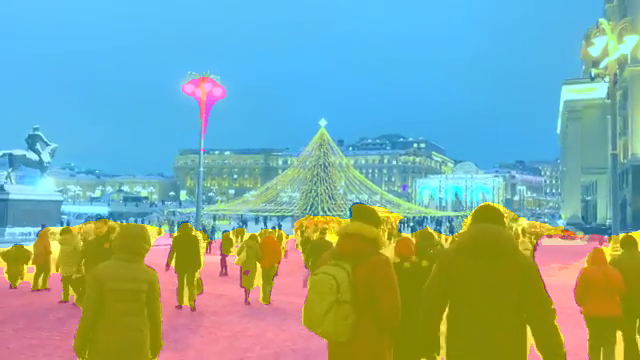

In [18]:
#
# Create segmentation images, make video, copy to file
#

seg_frames_1a = make_seg(main_imiages1)

make_video(seg_frames_1a, 'moscow_xmas1_segmentation_alt', 30, 'none')

# Replace 'source_path' with the path to your pickle file in Colab
source_path = '/content/moscow_xmas1_segmentation_alt.avi'

# Replace 'destination_path' with the path in your Google Drive where you want to save the file
destination_path = source_dir + 'moscow_combined_xmas/moscow_xmas1_segmentation_alt.avi'

# Copy the file to Google Drive
shutil.copyfile(source_path, destination_path)

cv2_imshow(seg_frames_1a[0])